## Analyze Wikipedia Crawl results

Author: J. Hickman

### Import

In [1]:
# conda install -c conda-forge wikipedia
# conda install -c conda-forge wordcloud
# pip install wikipedia_sections
import matplotlib.pyplot as plt
import wikipedia
import nltk
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read and re-format

In [3]:
#RELOAD FILE AND PRETEND THAT IS OUR STARTING POINT 
df=pd.read_csv('/Users/katherinemead/Documents/GitHub/anly-501-project-kam515/501-project-website/codes/02-data-cleaning/wiki-crawl-results.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; #y1=[]; y2=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
corpus=df["text"].to_list()
y2=df["sentiment"].to_numpy()

print("number of text chunks = ",len(corpus))
print(corpus[0:3])


(970, 3)
index = 0 : label = school district
index = 1 : label = school takeover
index = 2 : label = education reform
number of text chunks =  970
['12 public school function unit local usually operate several school largest urban suburban district operate hundred school practice varies significantly state case within state american operate independent local governmental unit grant authority within geographic limit created state law executive legislative power locally controlled policy operation independent case held board education depending state law member local board education often referred informally school board may elected appointed political office holder serve ex officio combination independent legally separate body corporate political', 'controlling law varies united state operate independent local governmental unit exclusive authority 12 public educational operation policy extent control set state level law litigation common law firm specialize school law handle litigation 

### Vectorize

In [4]:

# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# DOUBLE CHECK 
print(X.shape,y1.shape,y2.shape)

(970, 10943) (970,) (970,)


### Compute distance matrix

Distance between sentence vectors for a subset of data


(250, 250)
[[0.         0.10202887 0.02831827 ... 0.05150262 0.02188441 0.09220953]
 [0.10202887 0.         0.07331551 ... 0.05714545 0.06475239 0.05684021]
 [0.02831827 0.07331551 0.         ... 0.02114775 0.07188852 0.02524174]
 ...
 [0.05150262 0.05714545 0.02114775 ... 0.         0.         0.09181463]
 [0.02188441 0.06475239 0.07188852 ... 0.         0.         0.05852057]
 [0.09220953 0.05684021 0.02524174 ... 0.09181463 0.05852057 0.        ]]


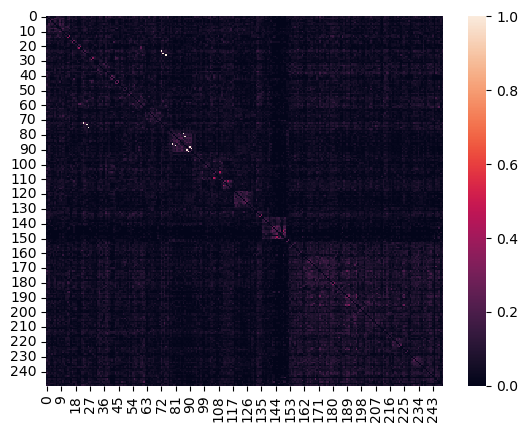

In [5]:
num_rows_keep=250
index=np.sort(np.random.choice(X.shape[0], num_rows_keep, replace=False))
# print(y1[index])
#print(index)
tmp1=X[index, :]
# print(tmp1.shape,tmp1.dtype,tmp1[:,].shape)

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]
        #print(vi.shape,vj.shape)

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) #cosine sim
        #dist=np.linalg.norm(vi-vj) #euclidean

        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2); #print(dij)
        # raise
dij=np.array(dij)

#normalize
# dij=(dij-np.min(dij))/(np.max(dij)-np.min(dij))

#Lower triangle of an array.
# dij=np.sort(dij,axis=0)
# dij=np.sort(dij,axis=1)
# dij=np.tril(dij, k=-1) 


import seaborn as sns
# sns.heatmap(np.exp(dij), annot=False) #,  linewidths=.05)
sns.heatmap(dij, annot=False) #,  linewidths=.05)
print(dij.shape)
print(dij)

### PCA

[0.01445629 0.00907487 0.00806664 0.00739062 0.00720606 0.00638342
 0.00586796 0.00540313 0.00512176 0.00500378]
[28.32678809 22.44342536 21.15998142 20.25393605 19.99943594 18.8232936
 18.04730541 17.31776045 16.86081141 16.66548629]


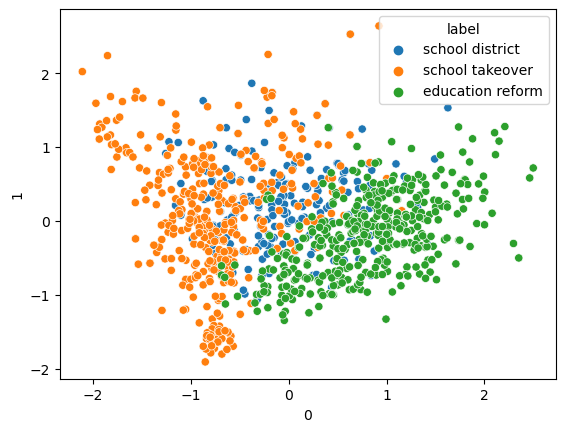

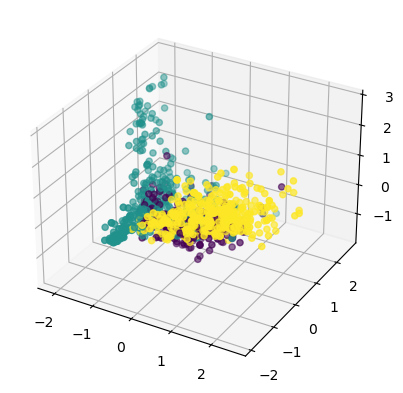

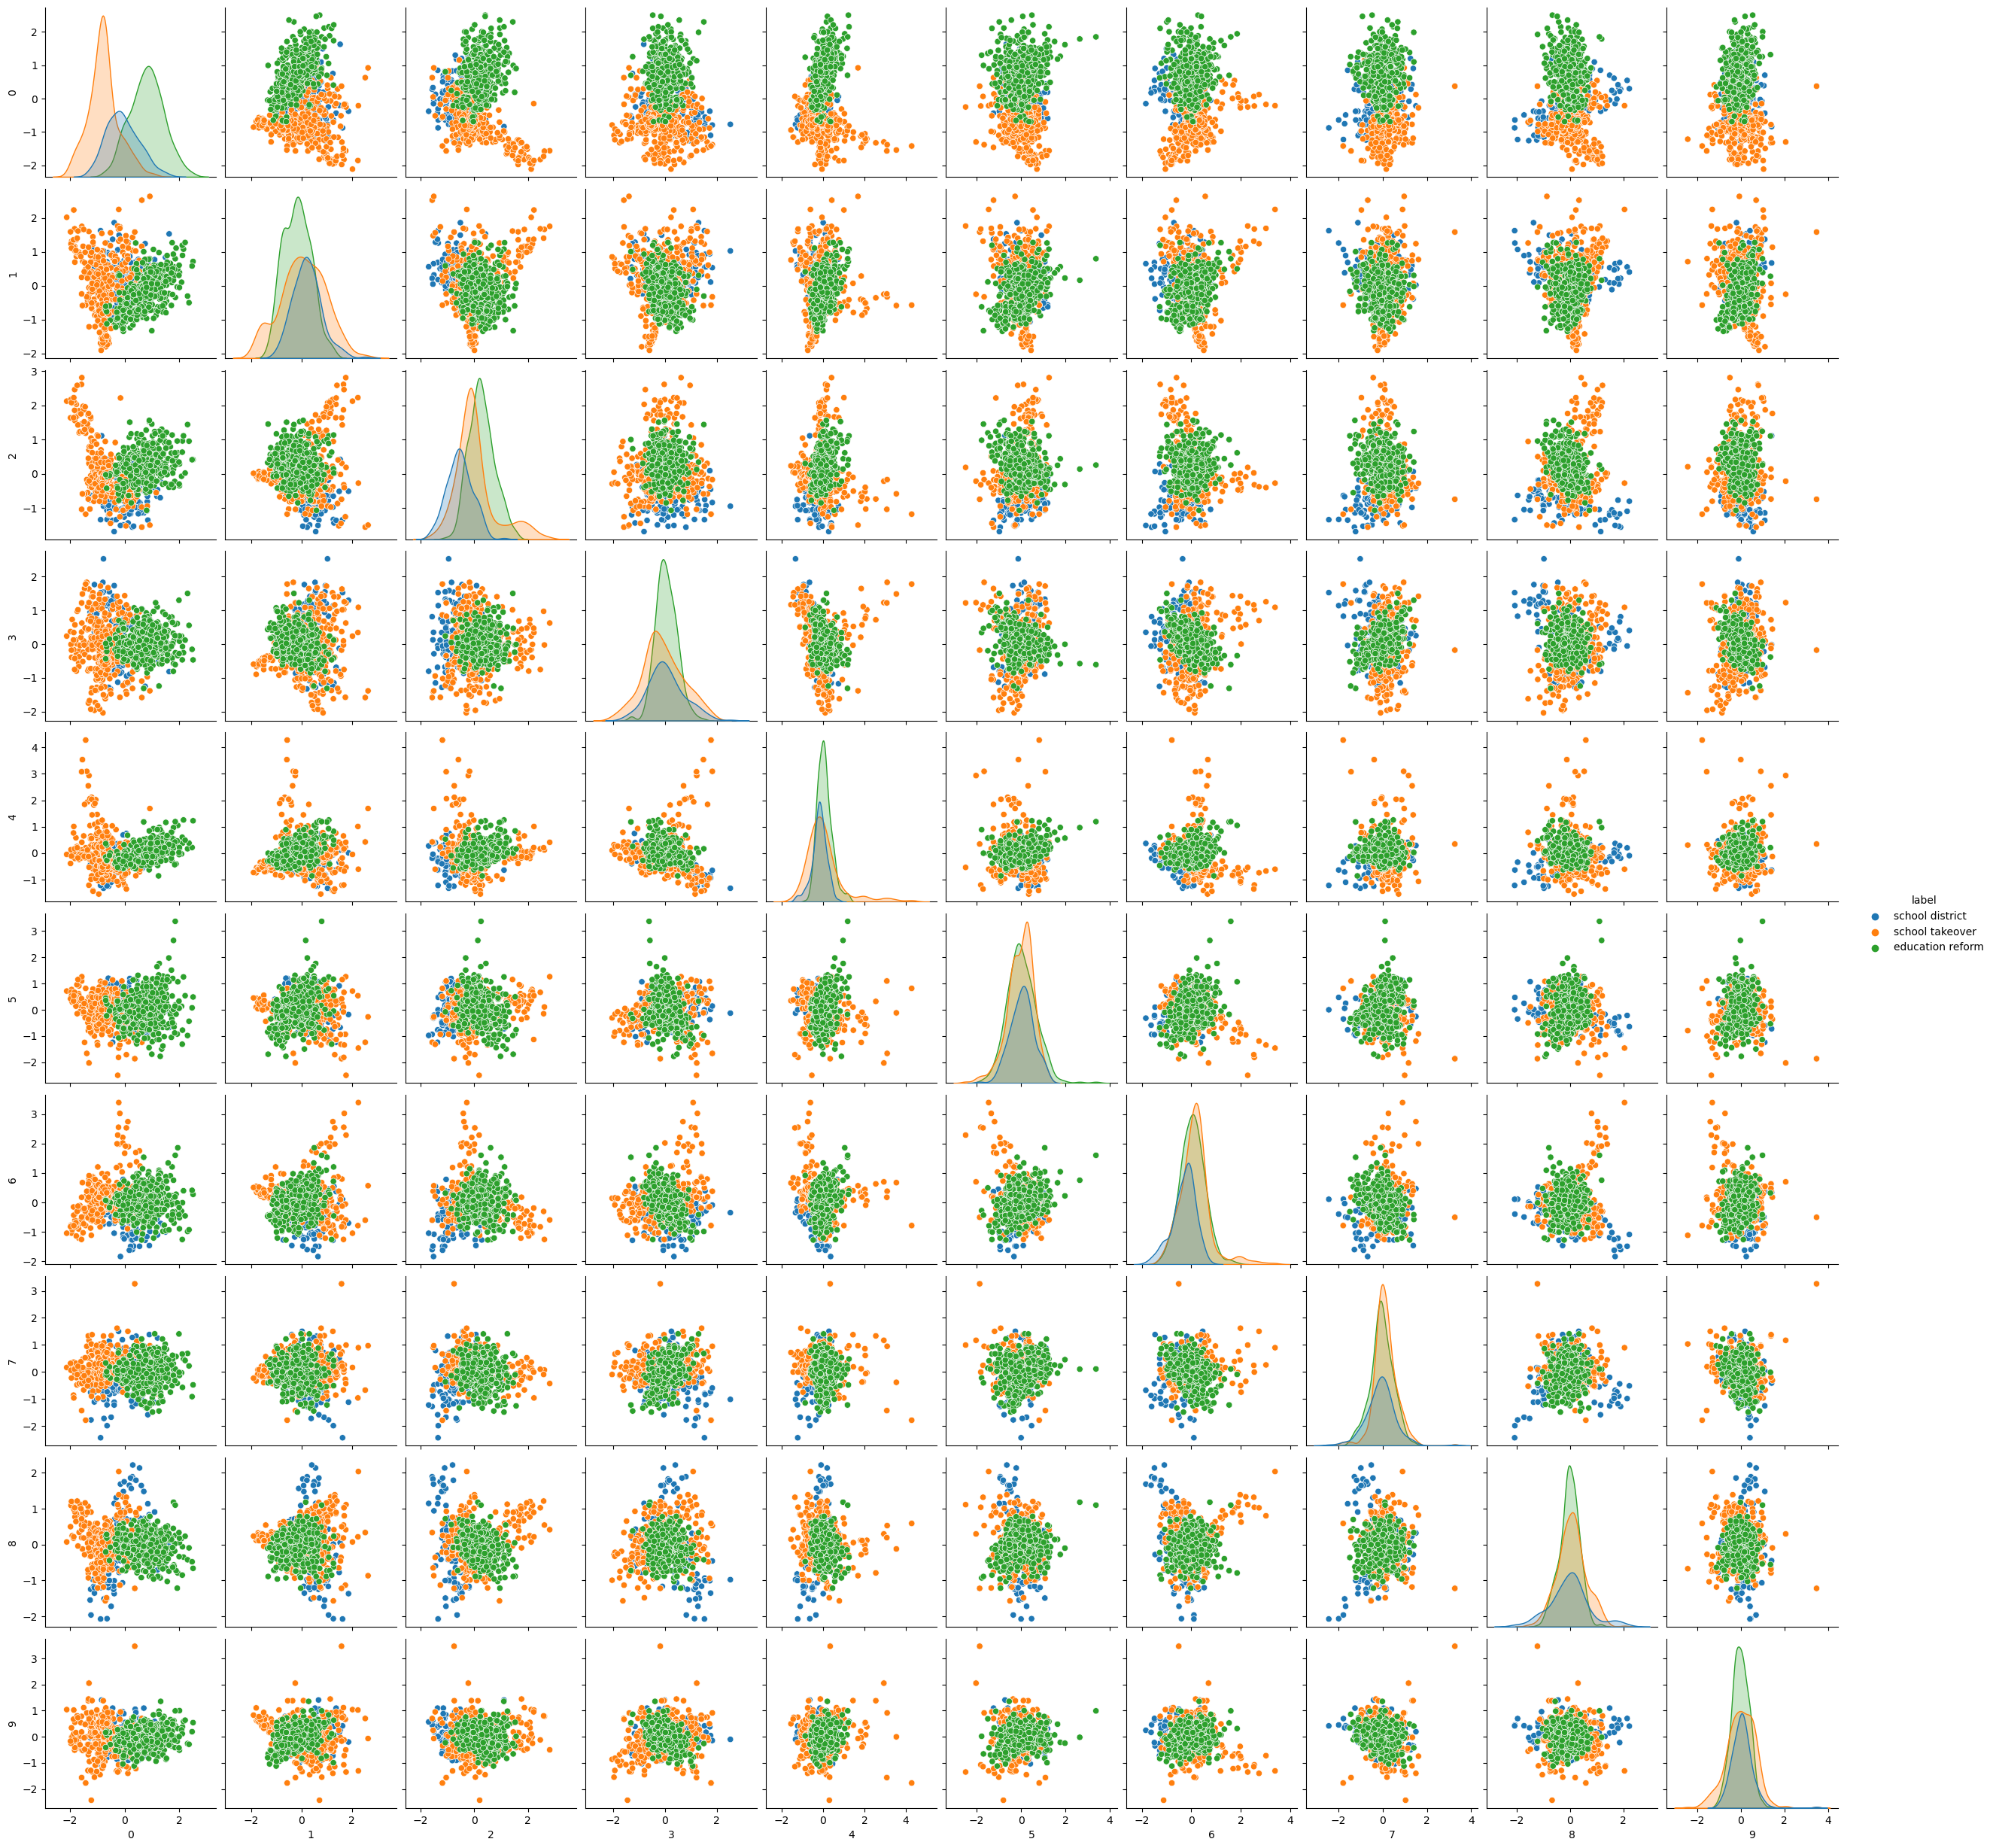

In [6]:
from sklearn.decomposition import PCA

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(X)
df2 = pd.DataFrame(data = principal_components) #, columns = ['PC1','PC2','PC3','PC4','PC5'])
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
sns.pairplot(data=df3,hue="label") #.to_numpy()) #,hue=df["label"]) #, hue="time")
plt.show()
